## Lawrence Abdulnour (20019894), Alexandre Marcil (C9464) and Louis-François Préville-Ratelle (708048)

## Q1 Practical Part

## 1, 2 & 3

#### I. Importing packages and visualizing the data.

In [13]:
### MNIST download ###
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz
import pickle, gzip, numpy as np

# Load the dataset
f = gzip.open('mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = pickle.load(f, encoding="bytes")
f.close()

--2019-02-18 02:21:56--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz.1’

mnist.pkl.gz.1      100%[===================>]  15.42M  7.86MB/s    in 2.0s    

2019-02-18 02:22:00 (7.86 MB/s) - ‘mnist.pkl.gz.1’ saved [16168813/16168813]



In [0]:
import gzip
import pickle
import copy
import numpy as np
import random
from random import seed
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [3]:
print(train_set[0].shape)
print(valid_set[0].shape)
print(test_set[0].shape)

(50000, 784)
(10000, 784)
(10000, 784)


3


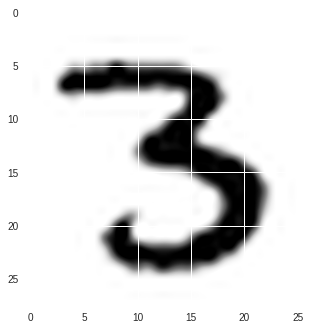

In [4]:
x=train_set[0].reshape(-1,28,28)
y=train_set[1]

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.imshow(x[12],interpolation='lanczos')
print(y[12])

#### II. Defining our class structure

In [0]:
class NN(object):
    
    def __init__(self, input_dim = 784, hidden_dim=[64,128], output_dim = 10, n_hidden=2, initialization = 'glorot'):
        
        
        """In this section, we define variables that will be often used in other
        methods of this class. We also initialize our parameters using the 
        initialize_weights method.
        """
        
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim 
        self.output_dim = output_dim
        self.n_hidden = n_hidden
        self.all_dim = [self.input_dim]+list(self.hidden_dim)+[self.output_dim]
        
        self.initialization = initialization
        self.initialize_weights()
        np.random.seed(0)
        
        
    def initialize_weights(self):
        
        
        """3 methods are defined in order to initialize weights throughout all 
        layers (all biases are set to zero):
        1)all weights parameters are initialized to zero (like biases),
        2)weights are drawn from a normal distribution between 0 and 1,
        3)weights are drawn from a normal distribution between -bound and bound.
        """
        
        
        W = {}
        b = {}
        
        random.seed(9001)
        
        for layer in range(1,len(self.all_dim)):
            
            shape_W = (self.all_dim[layer-1], self.all_dim[layer])
            shape_b = (1, self.all_dim[layer])
            
            if self.initialization == 'zero':
                W['W' + str(layer)] = np.zeros( shape_W )
                
            elif self.initialization == 'normal':
                W['W' + str(layer)] = np.random.normal(0, 1, shape_W)
            
            else:
                bound = (6/(self.all_dim[layer-1] + self.all_dim[layer]))**(0.5)
                W['W' + str(layer)] = np.random.uniform(-bound,bound,shape_W)
            
            b['b'+ str(layer)] = np.zeros( shape_b )
        
        self.W = W
        self.b = b
        
        return self.W, self.b
    
    def forward(self, X): 
        
        
        """Forward pass of inputs. Parameter X is a matrix of dimension 
        (n, self.input_dim) where n is the number of samples in a batch 
        (in stochastic gradient descent, n=1). 
        """
        
        
        ha = {}
        hs = {}
        x = X.reshape(-1, self.input_dim)
        
        for layer in range(1,len(self.all_dim)):
            
            W = self.W['W'+ str(layer)]
            
            b = self.b['b'+ str(layer)]
            
            ha['ha'+ str(layer)] = (x).dot(W) + b 
            
            if layer < len(self.all_dim) - 1:
                
                x = self.activation(ha['ha'+ str(layer)])
                
            else:
                
                x = self.softmax(ha['ha' + str(layer)]) 
            
            hs['hs' + str(layer)] = x
    
        self.ha = ha
        self.hs = hs
    
        return self.ha, self.hs
    
    def activation(self, X):
        
        """Activation function of hidden layers"""
    
            
        return np.maximum(X,0)
        
    def indic(self, X):
        
        """Derivative of activation function of hidden layers happens to be the
        indicator function.
        """
        
        return X > 0
    
    def softmax(self, X):
        
        
        """Using softmax as the activation function for the output of the model
        """
        
        X = np.atleast_2d(np.array(X))
        max_vals = np.amax(X, axis=1)
        max_vals = max_vals.reshape(max_vals.shape[0], 1)
        e = np.exp(X - max_vals)
        result = e / np.sum(e, axis=1, keepdims=True)
        
        return result
    
    def onehot(self, Y, m):
        
        
        """Onehot vector representation"""
        
        
        Y = np.atleast_2d(Y).transpose()
        onehot = np.zeros((len(Y), m))
        
        for i in range(len(Y)):
            
            onehot[i,Y[i].astype(int)] = 1
        
        return onehot
    
    def loss(self, X, Y):
        
        
        """Loss function used : is cross-entropy. The parameters are X and Y 
        where X is in the form of matrix, similarly to parameter X in the 
        forward pass, and Y is an array-like of labels for the corresponding 
        samples of X. 
        """
        
        
        return (-np.log(self.predict(X)) * self.onehot(Y,self.output_dim)).sum(axis=1).mean()
    
    def backward(self, X, Y):
        
        
        """Back propagation of outputs to train our model"""
        
        
        grad_hs = {}
        grad_ha = {}
        grad_W = {}
        grad_b= {}
        
        self.forward(X) #we execute the forward pass
        
        for layer in reversed(range(1,len(self.all_dim))):
            
            if layer == len(self.all_dim)-1:
                
                grad_ha[str(layer)] = self.hs['hs' + str(layer)] - self.onehot(Y, self.output_dim)     
                grad_W[str(layer)] = ((self.hs['hs' + str(layer-1)]).T).dot(grad_ha[str(layer)])
                grad_W[str(layer)] /= (X.shape[0])
                grad_b[str(layer)] = np.sum(grad_ha[str(layer)], axis=0)
                grad_b[str(layer)] /= (X.shape[0])
                
            elif layer == 1:
                
                grad_hs[str(layer)] = grad_ha[str(layer+1)].dot((self.W['W' + str(layer+1)]).T) 
                grad_ha[str(layer)] = grad_hs[str(layer)] * self.indic(self.ha['ha' + str(layer)])
                grad_W[str(layer)] = ((X).T).dot(grad_ha[str(layer)])
                grad_W[str(layer)] /= (X.shape[0])
                grad_b[str(layer)] = np.sum(grad_ha[str(layer)], axis=0)
                grad_b[str(layer)] /= (X.shape[0])
                
            else:
                
                grad_hs[str(layer)] = grad_ha[str(layer+1)].dot((self.W['W' + str(layer+1)]).T) 
                grad_ha[str(layer)] = grad_hs[str(layer)] * self.indic(self.ha['ha' + str(layer)])
                grad_W[str(layer)] = ((self.hs['hs' + str(layer-1)]).T).dot(grad_ha[str(layer)])
                grad_W[str(layer)] /= (X.shape[0])
                grad_b[str(layer)] = np.sum(grad_ha[str(layer)], axis=0)
                grad_b[str(layer)] /= (X.shape[0])
                
        grad_W = dict(sorted(grad_W.items(), key=lambda x: x[0]))
        grad_b = dict(sorted(grad_b.items(), key=lambda x: x[0]))
        
        self.grad_W = grad_W
        self.grad_b = grad_b
                
        return grad_W, grad_b
    
    def update(self, weights_gradient, bias_gradient, lrate):
        
        
        """Procedure to update gradients. Parameter lrate is 
        the learning rate to which the parameters are being updated.
        """
        
        
        weights_gradient.update({n: -lrate * weights_gradient[n] for n in weights_gradient.keys()})
        bias_gradient.update({n: -lrate * bias_gradient[n] for n in bias_gradient.keys()})
        
        self.W = {kv2[0]: kv1[1] + kv2[1] for kv1,kv2 in zip(weights_gradient.items(),self.W.items())}
        
        self.b = {kv2[0]: kv1[1] + kv2[1] for kv1,kv2 in zip(bias_gradient.items(),self.b.items())}

        
        return self.W, self.b 
            
    def train(self, X, Y, batch_size=1, epochs=25, lrate=0.03, print_stats = True):    
        
        
        """Training procedure."""
        
        
        train_err, valid_err, test_err, train_cost, valid_cost, test_cost = [], [], [], [], [], []
            
        for ep in range(epochs):
                
            for i in range(len(Y)//batch_size):
                    
                weights_gradient, bias_gradient = self.backward(X[i*batch_size:i*batch_size+batch_size,:],Y[i*batch_size:i*batch_size+batch_size])
            
                self.W, self.b = self.update(weights_gradient, bias_gradient, lrate)
                
            if (print_stats):
                
                print("-----Epoch " + str(ep) + "-----")
                
                print("--Errors--")
                train=self.error(X, Y)
                valid=self.error(self.valid_data,self.valid_labels)
                test=self.error(self.test_data,self.test_labels)
                train_err.append(train); valid_err.append(valid); test_err.append(test)
                print("Train: "+ str(train))
                print("Valid: "+ str(valid))
                print("Test: "+ str(test))
                
                print("--Mean costs--")
                train=self.loss(X, Y)
                valid=self.loss(self.valid_data,self.valid_labels)
                test=self.loss(self.test_data,self.test_labels)
                train_cost.append(train); valid_cost.append(valid); test_cost.append(test)
                print("Train: "+ str(train))
                print("Valid: "+ str(valid))
                print("Test: "+ str(test))

        self.train_err = train_err
        self.valid_err = valid_err
        self.test_err = test_err
        
        self.train_cost = train_cost
        self.valid_cost = valid_cost
        self.test_cost = test_cost
    
    def predict(self, X):
      
        """Predict procedure: forward pass"""
        
        dict_ha, dict_hs = self.forward(X)
        
        return dict_hs['hs' + str(len(self.all_dim)-1)]    
        
    def error(self, X, Y):
      
        """Determining error %"""
        
        selectmax = lambda y: self.onehot(np.argmax(y, axis =1), y.shape[1]) 
        preds=selectmax(self.predict(X))
        labels=self.onehot(Y, self.output_dim)
        results=preds*labels
    
        return 1-results.sum()/float(len(Y))
        
    def FD_gradients(self, X, Y, eps=0.0000005):
      
        """Validate gradients using finite difference."""
        
        m = self.all_dim[1]*self.all_dim[2]
        self.p = min(10, m)
        self.W['W2'] = self.W['W2'].reshape(-1, m)
        
        L_lower = []
        L_upper = []
        
        for i in range(self.p):
            
            self.W['W2'][:,i]-=eps
            self.W['W2'] = self.W['W2'].reshape(self.all_dim[1], self.all_dim[2])
            L_lower.append(self.loss(X,Y))
            
            self.W['W2'] = self.W['W2'].reshape(-1, m)
            self.W['W2'][:,i]+=(2*eps)
            self.W['W2'] = self.W['W2'].reshape(self.all_dim[1], self.all_dim[2])
            L_upper.append(self.loss(X,Y))
            
            self.W['W2'] = self.W['W2'].reshape(-1, m)
            self.W['W2'][:,i]-=eps

        gradients = np.array(L_upper)-np.array(L_lower)
    
        return gradients

    def set_valid(self,X,Y):
      
        """Setting the valid set."""
        
        self.valid_data=X  
        self.valid_labels=Y

    def set_test(self,X,Y):
      
        """Setting the test set."""
        
        self.test_data=X
        self.test_labels=Y

## 4

#### Analyzing the effect of different initialization methods. The architecture used include the following hyperparameters:

*   batch size = 1 (SGD)
*   number of epochs = 10
*   number of hidden layers = 2
*   number of units in both hidden layers = 512
*   learning rate = 0.005
*   non-linearity of hidden layers = relu
*   non-linearity of output layer = softmax

#### ***The following models also answers the subquestion "Train the MLP using the probability loss (cross entropy) as training criterion". We minimize this criterion to optimize the model parameters using stochastic gradient descent'' as we are using this optimization method to train all subsequent models. The only difference that distingushes them is the initialization method. 

#### Hence, all of them have the following number of parameters (scalar count):

*   number of weight parameters = (784x512) + (512x512) + (512x10) = 668, 672
*   number of bias parameters = 512 + 512 +10 = 1, 034
*   total number of parameters = 668, 672 + 1, 034 = **669, 706**


#### I.Training using stochastic gradient descent for 10 epochs and with *zero* initialization

In [7]:
model_zero=NN( hidden_dim = [512, 512], initialization = "zero")
model_zero.set_valid(valid_set[0], valid_set[1])
model_zero.set_test(test_set[0], test_set[1])
model_zero.train(train_set[0], train_set[1], batch_size=1, epochs=10, lrate=0.005, print_stats=True)

-----Epoch 0-----
--Errors--
Train: 0.88644
Valid: 0.8936
Test: 0.8865
--Mean costs--
Train: 2.301584204913442
Valid: 2.3020591539214545
Test: 2.301529161799745
-----Epoch 1-----
--Errors--
Train: 0.88644
Valid: 0.8936
Test: 0.8865
--Mean costs--
Train: 2.3015842049134307
Valid: 2.302059153921453
Test: 2.301529161799725
-----Epoch 2-----
--Errors--
Train: 0.88644
Valid: 0.8936
Test: 0.8865
--Mean costs--
Train: 2.3015842049134307
Valid: 2.302059153921453
Test: 2.301529161799725
-----Epoch 3-----
--Errors--
Train: 0.88644
Valid: 0.8936
Test: 0.8865
--Mean costs--
Train: 2.3015842049134307
Valid: 2.302059153921453
Test: 2.301529161799725
-----Epoch 4-----
--Errors--
Train: 0.88644
Valid: 0.8936
Test: 0.8865
--Mean costs--
Train: 2.3015842049134307
Valid: 2.302059153921453
Test: 2.301529161799725
-----Epoch 5-----
--Errors--
Train: 0.88644
Valid: 0.8936
Test: 0.8865
--Mean costs--
Train: 2.3015842049134307
Valid: 2.302059153921453
Test: 2.301529161799725
-----Epoch 6-----
--Errors--
Train

We can then plot the learning and validation curves for the model using 'zero' initialization. 

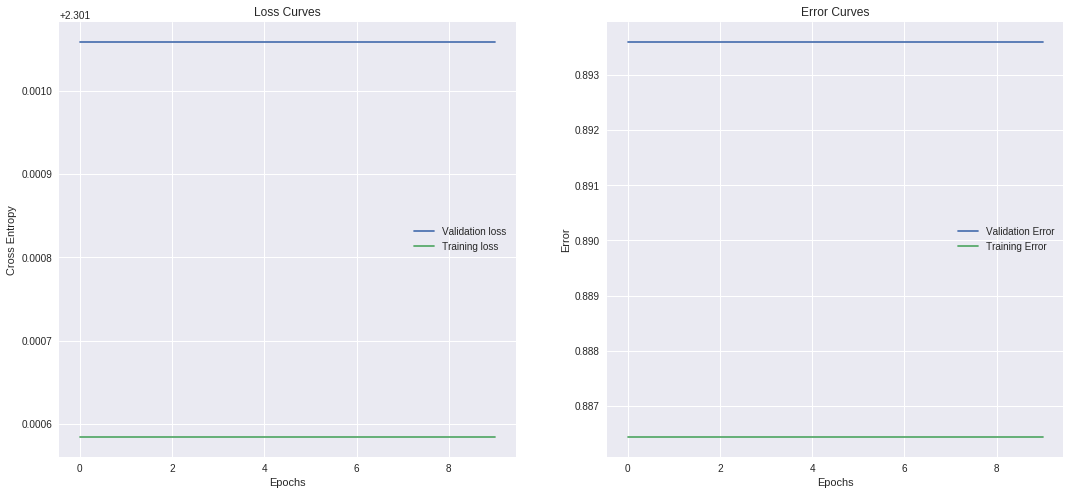

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))


ax1.plot(model_zero.valid_cost, label = 'Validation loss')
ax1.plot(model_zero.train_cost, label = 'Training loss')
ax1.set_ylabel('Cross Entropy')
ax1.set_xlabel('Epochs')
ax1.set_title('Loss Curves')
ax1.legend(loc="center right")
            
ax2.plot(model_zero.valid_err, label = 'Validation Error')
ax2.plot(model_zero.train_err, label = 'Training Error')
ax2.set_ylabel('Error')
ax2.set_xlabel('Epochs')
ax2.set_title('Error Curves')
ax2.legend(loc="lower right")
            
plt.legend()

Multiple problems emerge from initializing the weights all to zero. Indeed, when our model starts with equal weights,  all of them will have the same gradients and all of the neurons will end up having the same behavior as one another. Hence, when stuck in a local minima, the weights will keep updating to their same value and the model will be unable to continue learning. We can noticiably see the last statement in the loss and accuracy curves. If we study the error and accuracy logs, they are not changing at all as this initialization method prevents the network from learning. Therefore, to avoid this symmetry problem, we have to initialize the weights to unequal values.

#### II.Training using stochastic gradient descent for 10 epochs and with *normal* initialization

In [9]:
model_normal=NN(hidden_dim = [512, 512], initialization = "normal")
model_normal.set_valid(valid_set[0], valid_set[1])
model_normal.set_test(test_set[0], test_set[1])
model_normal.train(train_set[0], train_set[1], batch_size=1, epochs=10, lrate=0.005, print_stats=True)

-----Epoch 0-----
--Errors--
Train: 0.60476
Valid: 0.594
Test: 0.6087
--Mean costs--


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:151: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in multiply


Train: nan
Valid: nan
Test: nan
-----Epoch 1-----
--Errors--
Train: 0.54128
Valid: 0.5283
Test: 0.5488999999999999
--Mean costs--
Train: nan
Valid: nan
Test: nan
-----Epoch 2-----
--Errors--
Train: 0.5300400000000001
Valid: 0.51
Test: 0.5353
--Mean costs--
Train: nan
Valid: nan
Test: nan
-----Epoch 3-----
--Errors--
Train: 0.45602
Valid: 0.43679999999999997
Test: 0.45899999999999996
--Mean costs--
Train: nan
Valid: nan
Test: nan
-----Epoch 4-----
--Errors--
Train: 0.47982
Valid: 0.4617
Test: 0.48450000000000004
--Mean costs--
Train: nan
Valid: nan
Test: nan
-----Epoch 5-----
--Errors--
Train: 0.44436
Valid: 0.4263
Test: 0.44699999999999995
--Mean costs--
Train: nan
Valid: nan
Test: nan
-----Epoch 6-----
--Errors--
Train: 0.3698
Valid: 0.34330000000000005
Test: 0.37339999999999995
--Mean costs--
Train: nan
Valid: nan
Test: nan
-----Epoch 7-----
--Errors--
Train: 0.36360000000000003
Valid: 0.34140000000000004
Test: 0.363
--Mean costs--
Train: nan
Valid: nan
Test: nan
-----Epoch 8-----
--

Let us plot the learning and validation curves for the model using 'normal' initialization. Here, the loss curves cannot be plotted as explained further. 

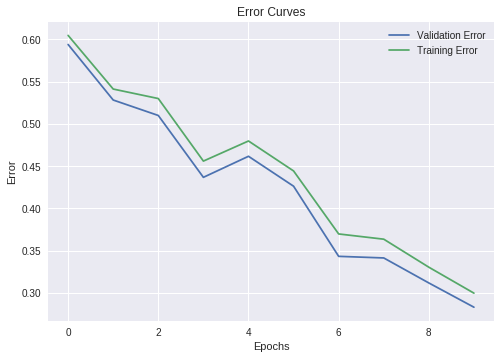

In [10]:
plt.plot(model_normal.valid_err, label = 'Validation Error')
plt.plot(model_normal.train_err, label = 'Training Error')
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.title('Error Curves')
plt.legend(loc="lower right")
            
plt.legend()

We once again see problems appearing, reiterating the importance of carefully choosing the random weight initialization. Indeed, random initialization is prone to vanishing or exploding gradient difficulties. The logs above indicate that we are experiencing a problem of vanishing gradient as a value too small (smaller than 1) is encountered in a logarithmic function. The problem, however, doesn't appear with fewer hidden units, but as considerable number of parameters are chosen, pre-activation values become extremely small (or explode, if we were in an exploding gradient situation) and the loss cannot be computed. To confirm our last findings, let us verify the pre-activation values of the last layer.

In [0]:
print(model_normal.hs['hs3'])

[[0.00000000e+000 0.00000000e+000 1.36856184e-321 ... 1.00000000e+000
  1.19656482e-216 6.65874409e-149]
 [3.33885007e-002 1.26698249e-002 1.44530540e-001 ... 6.15030276e-002
  2.35360801e-001 2.18238767e-001]
 [2.01570123e-170 1.00000000e+000 9.47804783e-059 ... 4.61882775e-025
  3.86680980e-038 4.37478502e-051]
 ...
 [4.28747617e-101 4.01204365e-020 2.74382656e-019 ... 3.36491155e-046
  3.05525906e-045 3.43934173e-047]
 [2.56234272e-042 1.27303540e-013 1.13181424e-037 ... 9.67859828e-015
  1.08429744e-011 3.81311069e-015]
 [0.00000000e+000 0.00000000e+000 8.96890258e-290 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]]


As expected, the values are extremely small, making the optimization of the loss function incredibly slow or, in our case, stop the neural network from training all together.

#### III.Training using stochastic gradient descent for 10 epochs and with *glorot* initialization

In [11]:
model_glorot=NN(hidden_dim = [512, 512])
model_glorot.set_valid(valid_set[0], valid_set[1])
model_glorot.set_test(test_set[0], test_set[1])
model_glorot.train(train_set[0], train_set[1], batch_size=1, epochs=10, lrate=0.005, print_stats=True)

-----Epoch 0-----
--Errors--
Train: 0.03805999999999998
Valid: 0.03990000000000005
Test: 0.04190000000000005
--Mean costs--
Train: 0.11978787562907704
Valid: 0.12832966641774332
Test: 0.13557733380862752
-----Epoch 1-----
--Errors--
Train: 0.022760000000000002
Valid: 0.03069999999999995
Test: 0.032399999999999984
--Mean costs--
Train: 0.07288441459378546
Valid: 0.09944003161094195
Test: 0.10179199997339765
-----Epoch 2-----
--Errors--
Train: 0.018900000000000028
Valid: 0.029299999999999993
Test: 0.031299999999999994
--Mean costs--
Train: 0.05697939196689078
Valid: 0.09519381380448452
Test: 0.10004540460977865
-----Epoch 3-----
--Errors--
Train: 0.013939999999999952
Valid: 0.026499999999999968
Test: 0.028000000000000025
--Mean costs--
Train: 0.04262948539076934
Valid: 0.09047338998648839
Test: 0.09304551257702608
-----Epoch 4-----
--Errors--
Train: 0.007460000000000022
Valid: 0.02190000000000003
Test: 0.02210000000000001
--Mean costs--
Train: 0.023292611411065183
Valid: 0.07608822234432

Plotting the learning and validation curves for the model using 'glorot' initialization. 

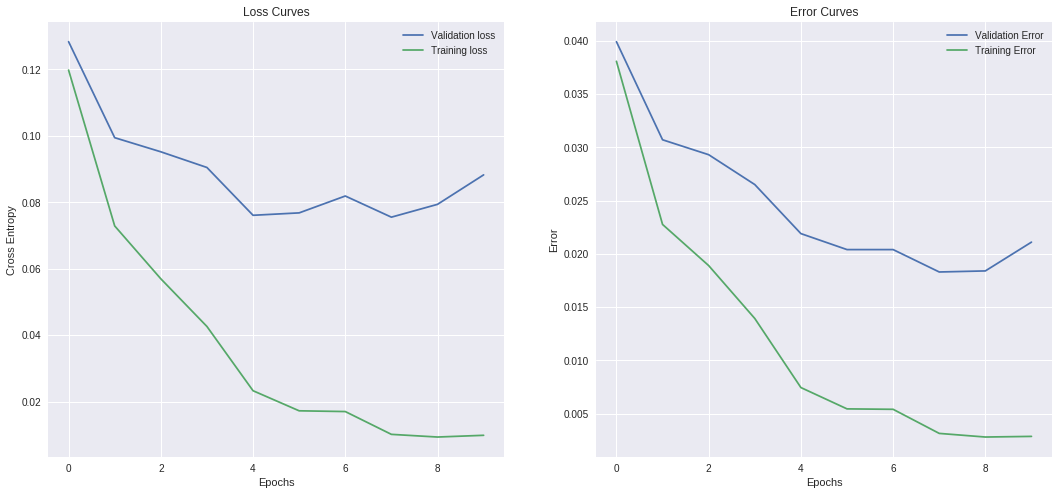

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))


ax1.plot(model_glorot.valid_cost, label = 'Validation loss')
ax1.plot(model_glorot.train_cost, label = 'Training loss')
ax1.set_ylabel('Cross Entropy')
ax1.set_xlabel('Epochs')
ax1.set_title('Loss Curves')
ax1.legend(loc="upper right")
            
ax2.plot(model_glorot.valid_err, label = 'Validation Error')
ax2.plot(model_glorot.train_err, label = 'Training Error')
ax2.set_ylabel('Error')
ax2.set_xlabel('Epochs')
ax2.set_title('Error Curves')
ax2.legend(loc="lower right")
            
plt.legend()

We can see now that our initialization using 'glorot' permits the model to appropriately learn and achieve good results. It is due to the fact that we truncated the variance of the distribution from which we generated our weights. This is done to also reduce the variance of output values in layers  and, in other words, to stop the variance of these values growing from layer to layer (hence limiting pre-activation values being very large or very small). It is a common strategy to avoid vanishing/exploding gradients. 

## 5.

####Hyperparameter search

We notice that with SGD and a deep neural net as ours, our training time was quite significant. We had already found an accuracy of over 97% with the glorot initialization and therefore the main motivation of our hyperparameter search was to find a model that was better or as performant, but that required less time to be trained. With the hyperparameters values of the 'model_glorot', we only changed the batch size to 32 and recorded the accuracies over different numbers of epochs as follows:



Epoch | Accuracy
--- | ---
10 | 95.66%
20 | 96.81%
30 | 97.30%



Although the accuracy with 30 epochs is encouraging, it wasn't as good as the 'model_glorot' and training over more epochs would have taken the same amount of time as SGD (and it would have defeated our purpose). We then tried the following models, only changing the batch size to 64 and the learning rate to 0.0005:

Epoch | Accuracy
--- | ---
10 | 87.63%
20 | 90.30%
30 | 91.34%

Noticeably, the results are poorer. Hence, as the 'glorot' model described previously already gave us an accuracy that is higher than 97% (97.89%), we decided to keep the same architecture but to only change the number of epochs. Indeed, we performed early stopping and trained our model on 9 epochs instead, since the valid accuracy was starting to increase at the 10th epoch while the train accuracy was still increasing (indicating that our model was starting to overfit our dataset-*see graphs above*). We finally end up with an accuracy of 98.16%.

**Note: Even though the test accuracies are printed, they were not used in the hyperparameter search process. **

In [0]:
model_final=NN(hidden_dim = [512, 512])
model_final.set_valid(valid_set[0], valid_set[1])
model_final.set_test(test_set[0], test_set[1])
model_final.train(train_set[0], train_set[1], batch_size=1, epochs=9, lrate=0.005, print_stats=True)

-----Epoch 0-----
--Errors--
Train: 0.03805999999999998
Valid: 0.03990000000000005
Test: 0.04190000000000005
--Mean costs--
Train: 0.11978787562907704
Valid: 0.12832966641774332
Test: 0.13557733380862752
-----Epoch 1-----
--Errors--
Train: 0.022760000000000002
Valid: 0.03069999999999995
Test: 0.032399999999999984
--Mean costs--
Train: 0.07288441459378546
Valid: 0.09944003161094195
Test: 0.10179199997339765
-----Epoch 2-----
--Errors--
Train: 0.018900000000000028
Valid: 0.029299999999999993
Test: 0.031299999999999994
--Mean costs--
Train: 0.05697939196689078
Valid: 0.09519381380448452
Test: 0.10004540460977865
-----Epoch 3-----
--Errors--
Train: 0.013939999999999952
Valid: 0.026499999999999968
Test: 0.028000000000000025
--Mean costs--
Train: 0.04262948539076934
Valid: 0.09047338998648839
Test: 0.09304551257702608
-----Epoch 4-----
--Errors--
Train: 0.007460000000000022
Valid: 0.02190000000000003
Test: 0.02210000000000001
--Mean costs--
Train: 0.023292611411065183
Valid: 0.07608822234432

#6.

#### Validating Gradients using Finite Difference

We perform gradient checking with the 'glorot' model previously defined.

In [0]:
true_glorot = model_glorot.grad_W['2'].reshape(-1)[:10]
print(true_glorot)

[-0.00000000e+00 -0.00000000e+00  2.20949625e-09  1.04431468e-10
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -8.29626625e-09
 -0.00000000e+00 -7.02021174e-09]


In [0]:
i = np.array([0, 1, 2, 3, 4])
k = np.array([1, 2, 3, 4, 5])
N= (k*10)**i
eps = 1/N

max_values=[]      
      
for value in np.nditer(eps):
  
  finite_glorot = model_glorot.FD_gradients(train_set[0][28], train_set[1][28], eps = value)
  max_values.append(np.max(np.abs(finite_glorot-true_glorot)))
  
print('Maximum difference values :', max_values)

Maximum difference values : [8.296266252630074e-09, 8.296266252630074e-09, 8.296266252630074e-09, 8.296266252630074e-09, 8.296266252630074e-09]


Text(0.5, 1.0, 'Difference between True and Approximate Gradients as a Function of N')

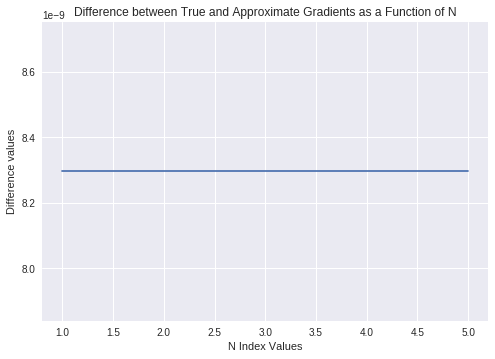

In [0]:
plt.plot(k, max_values)
plt.xlabel('N Index Values')
plt.ylabel('Difference values')
plt.title('Difference between True and Approximate Gradients as a Function of N')

After having tried multiple images, we see that the gradients of the finite difference method are stable, not letting us better analyze the difference. It is therefore best to test gradient checking on a model that was not trained for too long, as gradients are more susceptible of changing. This will help us better understand the effect of increasing the value of N. Let's do so with a model trained with one epoch:

In [0]:
model_FD=NN(hidden_dim = [512, 512])
model_FD.set_valid(valid_set[0], valid_set[1])
model_FD.set_test(test_set[0], test_set[1])
model_FD.train(train_set[0], train_set[1], batch_size=1, epochs=1, lrate=0.005, print_stats=True)

-----Epoch 0-----
--Errors--
Train: 0.03805999999999998
Valid: 0.03990000000000005
Test: 0.04190000000000005
--Mean costs--
Train: 0.11978787562907704
Valid: 0.12832966641774332
Test: 0.13557733380862752


In [0]:
true_gradients = model_FD.grad_W['2'].reshape(-1)[:10]
print('True gradients :', true_gradients)

True gradients : [-1.62603055e-07 -0.00000000e+00 -0.00000000e+00  9.58662325e-07
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -9.42036247e-06
 -0.00000000e+00 -5.58049153e-06]


We then try multiple values of epsilon to approximate our gradients and obtain the maximum value of  difference between our true and finite difference gradients.

In [0]:
i = np.array([0, 1, 2, 3, 4])
k = np.array([1, 2, 3, 4, 5])
N= (k*10)**i
eps = 1/N

max_values=[]      
      
for value in np.nditer(eps):
  
  finite_gradients = model_FD.FD_gradients(train_set[0][28], train_set[1][28], eps = value)
  max_values.append(np.max(np.abs(finite_gradients-true_gradients)))
  
print('Maximum difference values :', max_values)

Maximum difference values : [0.18399086139029847, 0.009203636966227103, 0.00020546280207038844, 9.420362470189442e-06, 9.420362470189442e-06]


Text(0.5, 1.0, 'Difference between True and Approximate Gradients as a Function of N')

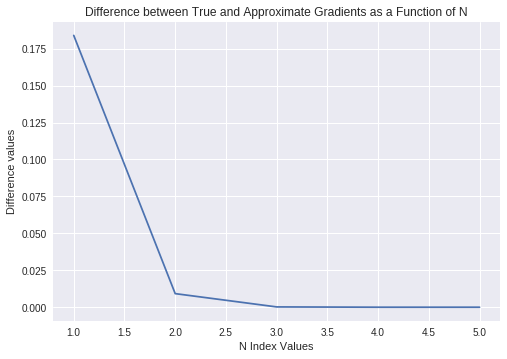

In [0]:
plt.plot(k, max_values)
plt.xlabel('N Index Values')
plt.ylabel('Difference values')
plt.title('Difference between True and Approximate Gradients as a Function of N')

As anticipated, when N increases, the disparity between the true and finite difference gradients decreases. In fact, just by analyzing the values plotted, we see that they are very small. Because the relu activation function was used in hidden layers, the curve above is not very smooth. This can be explained by the fact that the relu function itself is not a smooth function, thus making gradients and weights change more abruptly in some cases or not change at all. 

For instance, for a particular image, finite difference gradients (hence losses) where not changing and therefore, it was not possible to validate our gradients. An explanation would be that regardless of perturbing the weights, pre-activation values were still negative, leading outputs to being the same by definition of the relu function. 